<img src="https://farm66.staticflickr.com/65535/49055715328_092031af74_o.png"  width="150" />

<font size="5"> Photometric redshifts with random forest
    
<font size="2">
    
This notebook was adapted from the one developed by Gabriel Teixeira for the XIII Escola do CBPF - prof. Clécio R. Bom
<a href="www.clearnightsrthebest.com">clearnightsrthebest.com</a>
    
**Contact:** debom@cbpf.br</font>

<font size="2">

Please do not remove this disclaimer.</font>

In [ ]:
from astropy.io import fits
import os
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd

def open_fits_catalog(fits_file):
    hdu_list=fits.open(fits_file, ignore_missing_end=True)
    #print hdu_list
    hdu = hdu_list[1]    # table extensions can't be the first extension, so there's a dummy image extension at 0
    #print hdu.header
    cat_table = Table(hdu.data)
    cols=hdu.columns
    return cat_table, cols

In [ ]:
dados_dir = '/home/dados229/gabriel/escolacbpf/'
data_file = os.path.join(dados_dir, 'specz_catalog_ecbpf.fits')
data, _ = open_fits_catalog(data_file)



<function matplotlib.pyplot.show(close=None, block=None)>

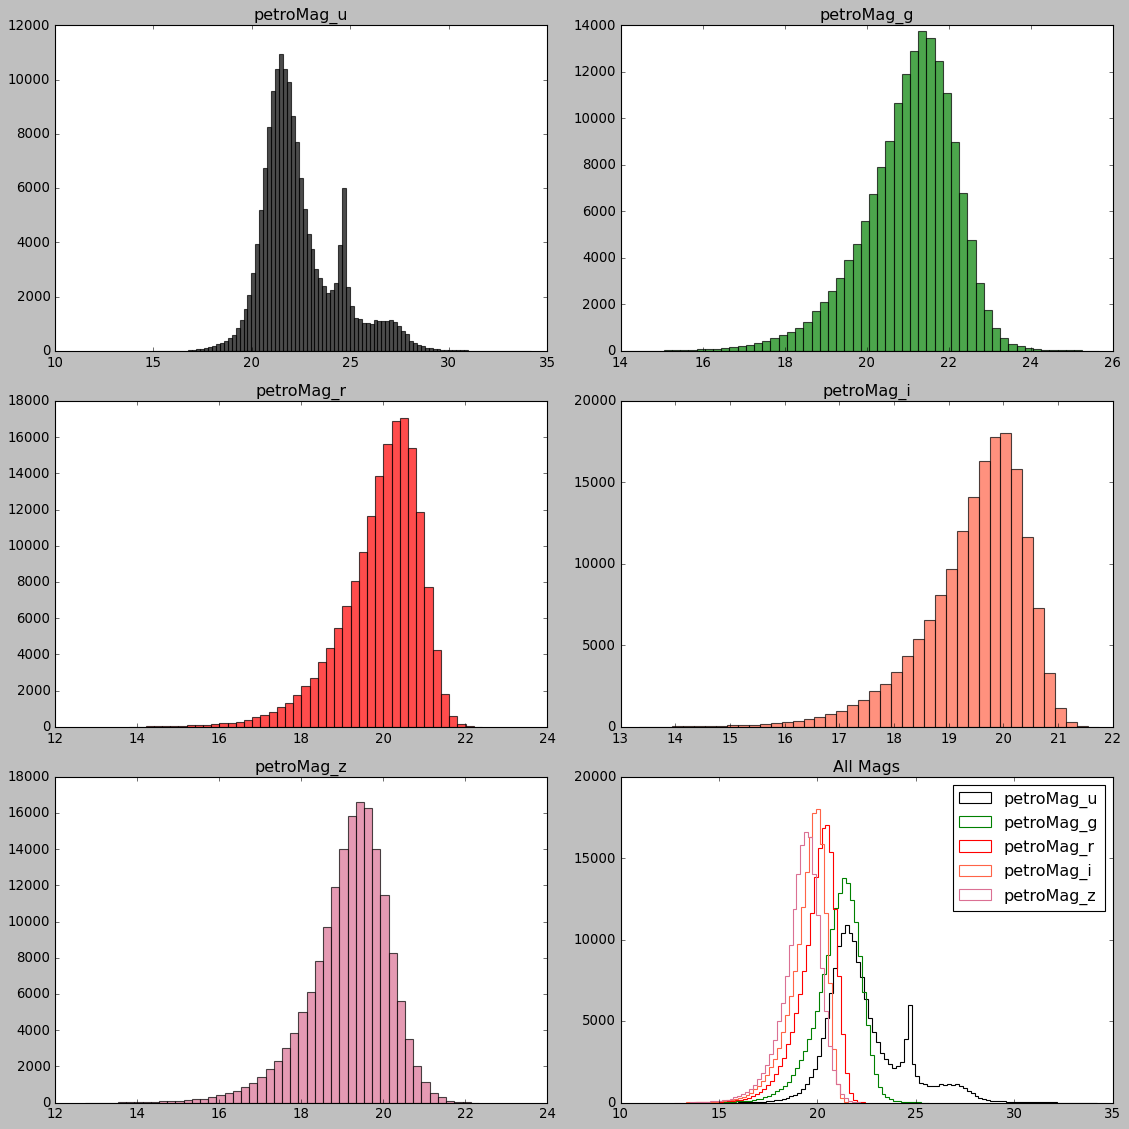

In [ ]:
### MAG PLOTS

mags = ['petroMag_'+band for band in 'ugriz']

key_list = mags 
color_list = ['black', 'green', 'red', 'tomato', 'palevioletred']
hor = 2
ver = 3

plt.style.use('classic')

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)

i=0
binsize=0.2
def binarange(arr):
    return np.arange(min(arr), max(arr)+binsize, binsize)


for v in range(ver):
    for h in range(hor):
        if v==2:
            ax = fig.add_subplot(gs[v, 0])
            bins = binarange(data.field(key_list[i]))
            ax.hist(data.field(key_list[i]), bins=bins, color=color_list[i], alpha=0.7)
            ax.set_title(key_list[i])
            
            ax = fig.add_subplot(gs[v, 1])
            for c, key in enumerate(key_list):
                bins = binarange(data.field(key))
                ax.hist(data.field(key), bins=bins, color=color_list[c], alpha=1, label=key, histtype='step')
            ax.set_title("All Mags")
            plt.legend()
            
            break
            i+=1
        
        
        mags = ['petroMag_'+band for band in 'ugriz']
        
        ax = fig.add_subplot(gs[v, h])
        bins = binarange(data.field(key_list[i]))
        ax.hist(data.field(key_list[i]), bins=bins, color=color_list[i], alpha=0.7)
        ax.set_title(key_list[i])
        i+=1

plt.show

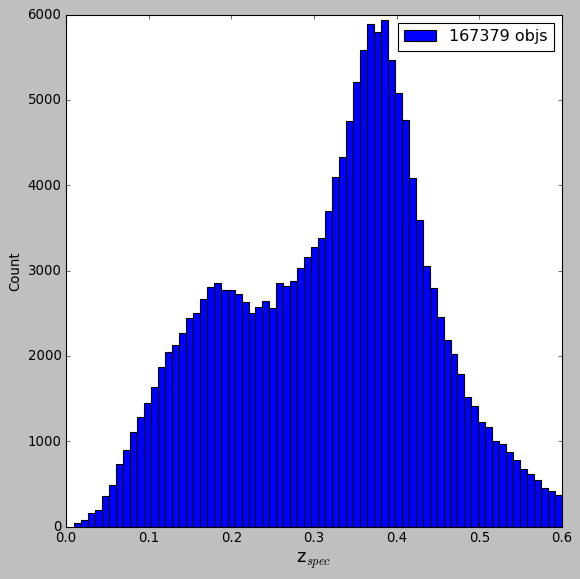

In [ ]:
#ZSPEC PLOTS

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.hist(np.array(data.field('z')), bins=70, color='blue', label=f'{len(data)} objs')
ax.set_xlabel('z$_{spec}$', fontsize=16)
ax.set_ylabel('Count')
plt.legend()

In [ ]:
#preprocessing

from sklearn.preprocessing import MinMaxScaler
np.random.seed(42)

train_percentual = 7/10
train_cut = np.random.uniform(0, 1, len(data)) < train_percentual
train_data = data[train_cut]

test_val_data = data[~train_cut]

test_percentual = 2/3
test_cut = np.random.uniform(0, 1, len(test_val_data)) < test_percentual

test_data = test_val_data[test_cut]
val_data = test_val_data[~test_cut]

print(f'Train Percent = {len(train_data)/len(data)*100:.2f}%')
print(f'Test Percent = {len(test_data)/len(data)*100:.2f}%')
print(f'Val Percent = {len(val_data)/len(data)*100:.2f}%')

#embaralhando os dados

train_shuffler = np.random.choice(len(train_data), len(train_data), replace=False)
train_data = train_data[train_shuffler]

test_shuffler = np.random.choice(len(test_data), len(test_data), replace=False)
test_data = test_data[test_shuffler]

val_shuffler = np.random.choice(len(val_data), len(val_data), replace=False)
val_data = val_data[val_shuffler]


x_train = np.array([train_data.field(mag) for mag in mags]).T
y_train = np.array(train_data.field('z'))

x_test = np.array([test_data.field(mag) for mag in mags]).T
y_test = np.array(test_data.field('z'))

x_val = np.array([val_data.field(mag) for mag in mags]).T
y_val = np.array(val_data.field('z'))

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

# np.max(x_test[:, 1])

Train Percent = 69.93%
Test Percent = 20.06%
Val Percent = 10.00%


In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=2)
regr = regressor.fit(x_train, y_train)

preds = regr.predict(x_test)

In [ ]:
### CALCULO DAS MÉTRICAS E PLOTS
def get_zstatistic(z,zspec):
    
    deltaz=z-zspec
    mean_bias=np.mean(deltaz)


    p16=np.percentile(deltaz,15.85)
    p84=np.percentile(deltaz,84.05)
    sigma68=0.5*(p84-p16)
    median_bias=np.percentile(deltaz,50)
    return mean_bias,median_bias,sigma68
    

def redshift_plot(z, zspec):
    
    plt.style.use('default')
    
    fig = plt.figure(figsize=(10, 8))
    
    mean_bias,median_bias,sigma68=get_zstatistic(z, zspec)


    text="\n $\sigma_{68}$: $"+str(round(sigma68,3))+"$"
    text+="\n Mean Bias: $"+str(round(mean_bias,3))+"$"
    text+="\n Median Bias: $"+str(round(median_bias,3))+"$"
    ax = fig.add_subplot()
    
    #dispersão entre photo-z e spec-z
    ax.scatter(np.array(zspec), np.array(z),
                       alpha = 0.5,
                       s=8,marker='o')
    
    #reta x = y
    reta = [0, max([max(zspec), max(z)])]
    ax.plot(reta, reta,
              ls='dashed', color='black', lw=0.5)
    
    #limites e legendas
    ax.set_ylim(min(z),max(z))
    ax.set_xlim(0,max(zspec))
    ax.set_ylabel("$z_{phot}$", fontsize=15)
    ax.set_xlabel("$z_{spec}$", fontsize=15)
    ax.text(0.7*max(zspec), .2*max(z), text, va="top", fontsize=12)
    
    plt.show()


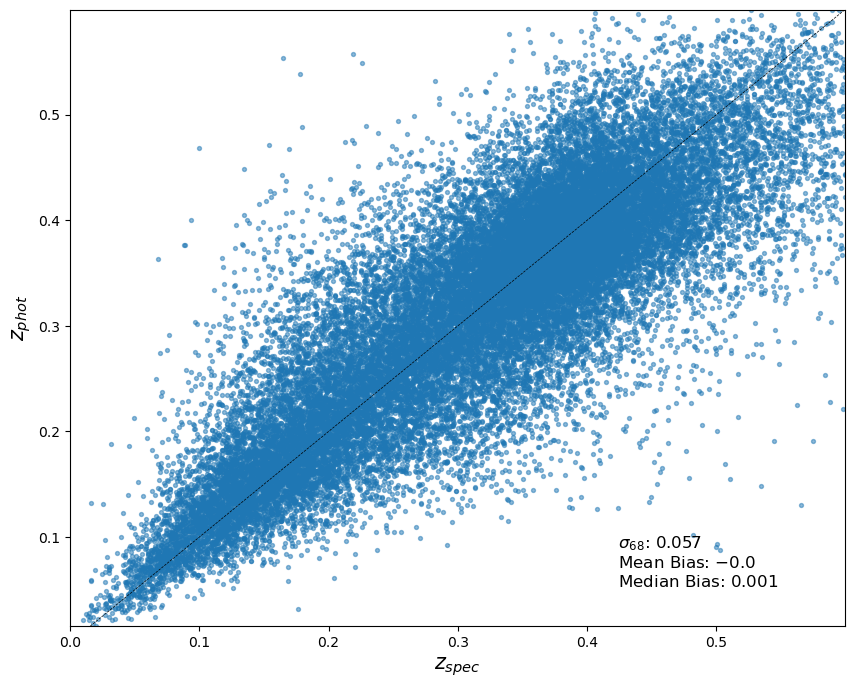

In [ ]:
redshift_plot(preds, y_test)
